$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\newcommand{\norm}[1]{\|#1\|_2}
$$

In [1]:
from __future__ import division

# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
from mpl_toolkits.mplot3d import Axes3D
if "bmh" in plt.style.available: plt.style.use("bmh");
    
# matplotlib objects
from matplotlib import mlab;
from matplotlib import gridspec;

# scientific
import numpy as np;
import scipy as scp;
import scipy.stats;

# scikit-learn
import sklearn;
from sklearn.kernel_ridge import KernelRidge;

# python
import random;

# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# rise config
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'start_slideshow_at': 'selected',
              'transition':'fade',
              'scroll': False
});

# EECS 545:  Machine Learning
## Lecture 11:  Bayesian Linear Regression & Gaussian Processes
* Instructor:  **Jacob Abernethy**
* Date:  February 17, 2015

*Lecture Exposition Credit: Ben & Valli*

## References

This lecture draws upon the following resources:

- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://www.springer.com/us/book/9780387310732).  2006.
- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[CS229]** Ng, Andrew.  [CS 229:  Machine Learning](http://cs229.stanford.edu/).  Autumn 2015.
    - [Gaussian Processes](http://cs229.stanford.edu/section/cs229-gaussian_processes.pdf)
    - [More on Gaussians](http://cs229.stanford.edu/section/more_on_gaussians.pdf)

## Outline

- Review Multivariate Gaussians
    - Partitioned Marginals and Conditionals
    - Bayes' Theorem for Gaussians
- Bayesian Linear Regression
- Gaussian Process Regression
    - Gaussian Processes

# More on Multivariate Gaussians

> Taken from **[PRML]** §2.3, **[MLAPP]** §4.3, 4.4, and **[CS229]**

### Review:  Multivariate Gaussians

Recall the **Multivariate Normal / Gaussian** distribution with 
- mean $\mu \in \R^D$
- covariance matrix $\Sigma \in \R^{D \times D}$

$$
\mathcal{N}(x | \mu, \Sigma)
= \frac{1}{(2\pi)^{D/2}} \frac{1}{|\Sigma|^{1/2}}
\exp\left[ -\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x - \mu) \right]
$$

### Partitioned Gaussian Distributions

Partition $x \sim \mathcal{N}(\mu, \Sigma)$ as $x = [x_a, x_b]^T$, and
- Mean and covariance
$$
\mu = \begin{bmatrix} \mu_a \\ \mu_b \end{bmatrix}
\quad
\Sigma = \begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
\end{bmatrix}
$$
- Precision Matrix
$$
\Lambda = \Sigma^{-1}
= \begin{bmatrix}
    \Lambda_{aa} & \Lambda_{ab} \\
    \Lambda_{ba} & \Lambda_{bb}
\end{bmatrix}
$$

### Partitioned Marginals

**Exercise:**  Marginals are obtained by taking a subset of rows and columns:

$$
\begin{align}
P(x_a)
&= \int P(x_a, x_b) \,dx_b \\
&= \mathcal{N}(x_a | \mu_a, \Sigma_{aa})
\end{align}
$$

> Marginals are Gaussian!

### Partitioned Marginals:  Example Code

In [8]:
def plot_mvn(sigmax, sigmay, mux, muy, corr):
    # dimensions
    radius = 3 * max(sigmax, sigmay);
    # create grid
    x = np.linspace(mux-radius, mux+radius, 100);
    y = np.linspace(muy-radius, muy+radius, 100);
    X, Y = np.meshgrid(x, y);
    
    # data limits
    xlim = (x.min(), x.max());
    ylim = (y.min(), y.max());
    
    # bivariate and univariate normals
    sigmaxy = corr * np.sqrt(sigmax * sigmay);
    Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mux, muy, sigmaxy);
    zx = np.sum(Z, axis=0); #mlab.normpdf(x, mux, sigmax);
    zy = np.sum(Z, axis=1); #mlab.normpdf(y, muy, sigmay);
    
    # figure
    fig = plt.figure(figsize=(8,8));
    
    # subplots
    gs = gridspec.GridSpec(2, 2, width_ratios=[5,1], height_ratios=[1,5]);
    ax_xy = fig.add_subplot(gs[1,0]);
    ax_x  = fig.add_subplot(gs[0,0], sharex=ax_xy);
    ax_y  = fig.add_subplot(gs[1,1], sharey=ax_xy);
    
    # plot
    ax_xy.imshow(Z, origin='lower', extent=xlim+ylim, aspect='auto');
    ax_x.plot(x, zx);
    ax_y.plot(zy, y);
    
    # hide labels
    ax_x.xaxis.set_visible(False);
    ax_x.yaxis.set_visible(False);
    ax_y.xaxis.set_visible(False);
    ax_y.yaxis.set_visible(False);
    
    # layout & title
    plt.tight_layout();

### Partitioned Marginals:  Bivariate Example

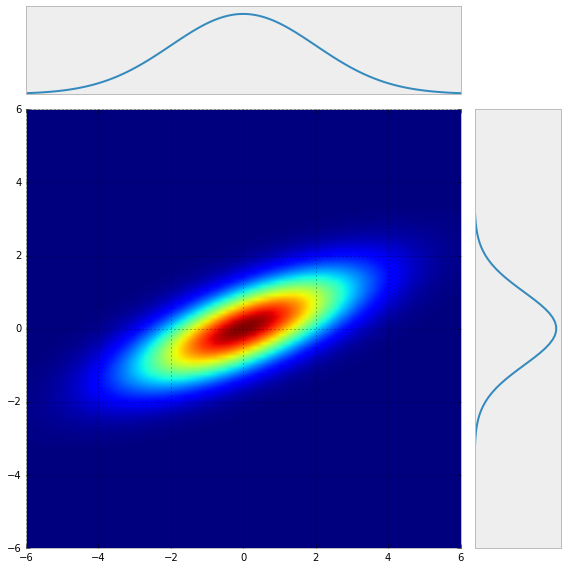

In [9]:
# sigmax, sigmay, mux, muy, corr
plot_mvn(2, 1, 0, 0, 1);

### Partitioned Conditionals

**Exercise:** Conditionals are given by

$$
\begin{align}
P(x_a | x_b)
    &= \mathcal{N}(x_a | \mu_{a|b}, \Sigma_{a|b}) \\
\Sigma_{a|b}
    &= \Lambda_{aa}^{-1} 
    = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1} \Sigma_{ba} \\
\mu_{a|b}
    &= \Sigma_{a|b} \left[
            \Lambda_{aa}\mu_a - \Lambda_{ab}(x_b-\mu_b) 
        \right] \\
    &= \mu_a - \Lambda_{aa}^{-1}\Lambda_{ab}(x_b - \mu_b) \\
    &= \mu_a + \Sigma_{ab} \Sigma_{bb}^{-1} (x_b - \mu_b)
\end{align}
$$

### Partitioned Conditionals

> Obtained by "slicing" the joint pdf

<img src="images/partitioned-conditionals.png">

### Linear Gaussian Systems:  Model

Suppose $x \in \R^{D_x}$ and $y \in \R^{D_y}$, and
$$
\begin{align}
x &\sim \mathcal{N}(\mu_x, \Sigma_x) \\
y | x &\sim \mathcal{N}(Ax + b, \Sigma_y)
\end{align}
$$

for fixed $A \in \R^{D_y \times D_x}$ and $b \in \R^{D_y}$.

### Linear Gaussian Systems:  Bayes' Theorem

**Exercise:**  Show that

$$
\boxed{P(y) = \mathcal{N}(y | A\mu_x + b, \Sigma_y + A\Sigma_x A^T)}
$$

### Linear Gaussian Systems:  Bayes' Theorem

**Exercise:** Show that
$$
\boxed{P(x|y) = \mathcal{N}(x | \mu_{x|y}, \Sigma_{x|y})}
$$
where
$$
\begin{align}
\Sigma_{x|y}^{-1} &= \Sigma_x^{-1} + A^T \Sigma_y^{-1} A \\
\mu_{x|y} &= \Sigma_{x|y} \left[
        A^T \Sigma_y^{-1} (y-b) + \Sigma_x^{-1} \mu_x 
    \right]
\end{align}
$$

# Bayesian Linear Regression 

> Taken from **[PRML]** §3.3, **[MLAPP]** §7.6, and **[CS229]**

### Review:  Regression

**Data:**  Given data $\mathcal{D}=\{ (x_k, t_k) \}_{k=1}^N$
- Observations $x = \{ x_1, \dots, x_N \}$
- Target values $t = \{t_1, \dots, t_N \}$

**Predict:** Learn a function $y(x) = t$, e.g.
- Linear Regression, $y(x) = w^T \phi(x)$
- Kernel Regression, Locally Weighted Regression, etc.

### Review:  Linear Regression

In linear regression, we had a **likelihood** and **prior**
$$
\begin{align}
w &\sim \mathcal{N}(w_0, S_0) \\
t | x, w, \beta &\sim \mathcal{N}(w^T \phi(x_n), \beta^{-1})
\end{align}
$$

- Alternatively, $y = w^T x + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \beta^{-1})$
- Ridge regression corresponds to $w_0 = 0$ and $S_0 = \tau^2 I$.

### Review:  Linear Regression

Regularized linear regression gave a **MAP Estimate**:
$$
w_{MAP} = (\lambda I + \Phi^T \Phi)^{-1} \Phi^T t
$$

- where $\lambda$ is a function of $S_0$ and $\beta$
- this is a *point estimate* of the full posterior $P(w | \mathcal{D})$

### Review:  Bayesian Updating

Bayesian Linear Regression will compute the full posterior.  Recall that

$$
\text{posterior} \propto \text{likelihood} \cdot \text{prior}
$$

> weight the *data likelihood* by your *prior beliefs*

### Bayesian Linear Regression

Instead, **Bayesian Linear Regression** computes the full posterior over the weights,
$$
\begin{align}
P(w | x,t)
&\propto P(t | x,w) P(w) \\
&= \mathcal{N}(t \, | \, w^T \phi(x), \beta^{-1}) \mathcal{N}(w \, |\, w_0, S_0) \\
&= \mathcal{N}(w \, | \, m_N, S_N)
\end{align}
$$

where
- $m_N = S_N(S_0^{-1} w_0 + \beta \Phi^T t)$
- $S_N^{-1} = S_0^{-1} + \beta \Phi^{T} \Phi$

We got this simply by apply the calcuations on Linear Gaussian Systems (see prev. slides)!

### BLR:  Simplifying the Prior

Assume $w_0 = 0$ and $S_0 = \alpha^{-1} I$ (zero-mean isotropic Gaussian):

$$
w \sim \mathcal{N}(0, \alpha^{-1} I)
$$

**Exercise:**  By Bayes' Rule for Gaussians, the corresponding posterior is:

$$
P(w | x,t) = \mathcal{N}(w | m_N, S_N)
$$

where
* $m_N = \beta S_N \Phi^T t$
* $S_N^{-1} = \alpha I + \beta \Phi^T \Phi$



### BLR:  Using the Posterior

We have just shown the posterior is:
$$
P(w | x,t) = \mathcal{N}(w | m_N, S_N)
$$

where $m_N = \beta S_N \Phi^T t$ and $S_N^{-1} = \alpha I + \beta \Phi^T \Phi$
- Note the **posterior mean** is $m_N = w_{MAP}$ from regularized linear regression!
- Now we also have the **posterior variance** $S_N$!  This tells us how *confident* we are in our prediction $w_{MAP}$.

## Break time!

<img src="https://s-media-cache-ak0.pinimg.com/originals/b2/75/7b/b2757b382dfb6a2e76d95ca85d0556c0.gif"/>

### Sequential Bayesian Learning

**Note:** The posterior and prior are both Gaussians.
- If our data is *streaming*, we can use the posterior for one observation as a prior for the next set of observations.
- Starting from a fixed prior, sequentially update our beliefs as new data arrives.

This is **Bayesian Updating**.

### Sequential Bayesian Learning

**Simple model**: $y(x,w) = w_0 + w_1 x$
$$\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$

<img src = "images/sbl.png">

$
\text{(A)}  \quad \quad \quad
\quad \text{(B) } p(\mathbf{w} | \mathbf{x},t)
\quad \text{(C) samples of } \mathbf{w} |  \mathbf{x},t
$

### Sequential Bayesian Learning

**Simple model**: $y(x,w) = w_0 + w_1 x$
$$\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$

We can sample lines (*hypotheses*) from the posterior:

<img src = "images/sbl2.png">

$$
\text{(A) } p(t | \mathbf{x}, \mathbf{w}) 
\quad \text{(B) } p(\mathbf{w} | \mathbf{x},t)
\quad \text{(C) samples of } \mathbf{w} |  \mathbf{x},t
$$

### Sequential Bayesian Learning

**Simple model**: $y(x,w) = w_0 + w_1 x$
$$\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$

We can sample lines (*hypotheses*) from the posterior:

<img src = "images/sbl3.png">

$$
\text{(A) } p(t | \mathbf{x}, \mathbf{w}) 
\quad \text{(B) } p(\mathbf{w} | \mathbf{x},t)
\quad \text{(C) samples of } \mathbf{w} |  \mathbf{x},t
$$

### Sequential Bayesian Learning

**Simple model**: $y(x,w) = w_0 + w_1 x$
$$\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$

We can sample lines (*hypotheses*) from the posterior:
<img src = "images/sbl4.png">

$$
\text{(A) } p(t | \mathbf{x}, \mathbf{w}) 
\quad \text{(B) } p(\mathbf{w} | \mathbf{x},t)
\quad \text{(C) samples of } \mathbf{w} |  \mathbf{x},t
$$

### Predictive Distribution

Our real goal is to predict $t$ given new $x$ using the **predictive distribution**,

$$
\begin{align}
P(t | x, \mathcal{D})
&= \int_w P(t | x, w, \mathcal{D}) P(w | \mathcal{D}) \, dw \\
&= \int_w \mathcal{N}(t | w^T\phi(x), \beta^{-1}) \mathcal{N}(0, \alpha^{-1}I)
\end{align}
$$

**Exercise:**  Show that $P(t | x, \mathcal{D}) = \mathcal{N}(t | m_N^T \phi(x), \sigma_N^2(x))$, where
- $\sigma_N^2(x) = \frac{1}{\beta} + \phi(x)^T S_n \phi(x)$

Intuitively, this corresponds to noise in data + uncertainty in $w$.

### Predictive Distribution:  Samples

Using 9 Gaussian basis functions $ \phi_j(x) = exp\left\{ -\frac{(x- \mu_j)}{2s^2} \right\}$

<img src="images/predictive-n1.png">

$N=1$ observed point

### Predictive Distribution:  Samples

<img src="images/predictive-n2.png">

$N=2$ observed points

### Predictive Distribution:  Samples

<img src="images/predictive-n4.png">

$N=4$ observed points

### Predictive Distribution:  Samples

<img src="images/predictive-n25.png">

$N=25$ observed points

# Gaussian Processes

> Taken from **[CS229]** and **[MLAPP]**

### Gaussian Processes

**Motivation**: Here are some data points. What function did they come from?
- GPs are a nice way of expressing “priors on functions”
- Applications: Regression and Classification
<img src="images/gp1.png">

### Gaussian Processes:  Motivation

**Multivariate Gaussians** are useful for modeling *finite* collections of real-valued variables.
- Nice analytical properties
- Distribution over **random vectors**
- Easily model *correlations* between variables

**Gaussian Processes** extend Multivariate Gaussians to *infinite-sized* collections of real-valued variables.
- Distribution over **random functions**

## How can we parameterize probability distributions over functions?

### Distributions over Functions:  Finite Domain

Consider the following simple example:
- Let $\mathcal{X} = \{ x_1, \dots, x_m \}$ be any finite set.
- Let $\mathcal{H}$ be the set of all functions $h : \mathcal{X} \mapsto \R$.

For example, one function $h_0 \in \mathcal{H}$ is
$$
h_0(x_1) = 5 \quad h_0(x_2) = 2.3 \quad \cdots \quad h_0(x_{m-1}) = -\pi \quad h_0(x_m) = 8
$$

Any function $h \in \mathcal{H}$ can be represented as a vector:
$$
\vec{h_0} = [5, 2.3, \dots, \pi, 8]
$$

### Distributions over Functions:  Finite Domain

To specify a distribution over $\mathcal{H}$, exploit the one-one mapping to $\R^m$
- Assume a distribution over vectors, $\vec{h} \sim \mathcal{N}(\vec{\mu}, \sigma^2 I)$.

This **induces** a distribution over $\mathcal{H}$ given by likelihoods at each *"sample point"*:
$$
P(h) = P(\vec{h}) = \prod_{k=1}^m \frac{1}{\sqrt{2\pi} \sigma} \exp\left[ -\frac{1}{2\sigma^2} ( f(x_k) - \mu_k )^2 \right]
$$

### Distributions over Functions:  Infinite Domain

A **stochastic process** is a collection of random variables, $f = \{ f(x) \}_{x \in \mathcal{X}}$ with index set $\mathcal{X}$, e.g.
- Dirichlet Processes, Poisson Processes, etc.

A **Gaussian Process** is a stochastic process such that any finite subcollection of random variables has a multivariate Gaussian distribution

### Gaussian Processes:  Definition

We say $f(\cdot) \sim \mathcal{GP}(m, k)$ is drawn from a Gaussian process with
- mean function $m(\cdot) : \mathcal{X} \mapsto \R$
- covariance or kernel function $k(\cdot, \cdot) : \mathcal{X} \times \mathcal{X} \mapsto \R$

provided that for any finite set $\{x_1, \dots, x_m\} \subset \mathcal{X}$, the associated random variables have distribution
$$
\begin{bmatrix}
f(x_1) \\ \vdots \\ f(x_m)
\end{bmatrix}
\sim
\mathcal{N}\left(
\begin{bmatrix}
m(x_1) \\ \vdots \\ m(x_m)
\end{bmatrix},
\begin{bmatrix}
k(x_1, x_1) & \cdots & k(x_1, x_m) \\
\vdots & \ddots & \vdots \\
k(x_m, x_1) & \cdots & k(x_m, x_m)
\end{bmatrix}
\right)
$$

### Gaussian Processes:  Interpretation

Intuitively, $f \sim \mathcal{GP}(m, k)$ is an 
- extremely high-dimensional vector
- drawn from an extremely high-dimensional Gaussian

Each dimension corresponds to an element $x \in \mathcal{X}$,
- the corresponding component of the vector represents $f(x)$

### Gaussian Processes:  Mean and Covariance

The **mean function** $m(\cdot) : \mathcal{X} \mapsto \R$ can be any function.
- For most applications, set $m \equiv 0$.

The **covariance function** $k(\cdot, \cdot) : \mathcal{X} \times \mathcal{X} \mapsto \R$ must be a valid kernel.
- $f(x)$ and $f(x')$ will have high covariance if $x$ and $x'$ are "nearby"
- Therefore, kernel controls **smoothness**

### Gaussian Processes:  Example

When $m \equiv 0$, the choice of kernel defines the prior.
- (Left) Gaussian Kernel $k(x, x') = exp(−\theta ||x − x'||_2^2)$
- (Right) Exponential Kernel $k(x, x') = exp(−\theta ||x − x'||_1)$

Samples from a Gaussian Process:

<img src="images/gpleft.png">

### Linear Regression Revisited

**Model:**  Assume $y \approx w^T \phi(x)$ is a combination of $M$ fixed basis functions.
$$
\begin{align}
w &\sim \mathcal{N}(w_0, S_0) \\
y | x, w, \beta &\sim \mathcal{N}(w^T \phi(x_n), \beta^{-1})
\end{align}
$$

Given training points $x_1, \dots, x_N$, what is the joint distribution $P(\vec{y})$ of $y(x_1), \dots, y(x_N)$?
$$
\vec{y} = \Phi w = \begin{bmatrix} y(x_1) & \cdots & y(x_N) \end{bmatrix}^T
$$

### Linear Regression Revisited

Note $\vec{y} = \Phi w$ is a linear combination of Gaussians $w$, so is itself Gaussian!

$$
\begin{align}
\mathrm{E}[\vec{y}]
    &= \Phi E[w] = 0 \\
\mathrm{Cov}[\vec{y}] 
    &= \mathrm{E}[yy^T]
    = \Phi \mathrm{E}[ww^T] \Phi^T
    = \frac{1}{\alpha} \Phi \Phi^T
    = K
\end{align}
$$

where $K = [ k(x_i, x_j) ]_{i,j} \in \R^{N \times N}$ is the **Gram Matrix** over the training data with kernel
$$
k(x_i, x_j) = \frac{1}{\alpha} \phi(x_i)^T \phi(x_j)
$$

### Bayesian Linear Regression

So, Bayesian Kernel Linear Regression is a Gaussian Process!
- Kernel $k(\cdot, \cdot)$ is dot product in feature space.
$$
\begin{align}
y &= f(x) + \epsilon \\
f &\sim \mathcal{GP}(0, k(\cdot, \cdot)) \\
\epsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}
$$

> Features in BLR $\iff$ Kernel functions for GPs

### Gaussian Process Regression

In general, $k(\cdot, \cdot)$ can be any valid kernel,

$$
\begin{align}
y &= f(x) + \epsilon \\
f &\sim \mathcal{GP}(0, k(\cdot, \cdot)) \\
\epsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}
$$

> See the book for more details.